In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

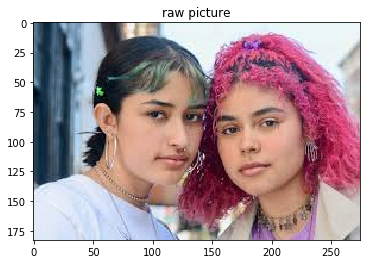

In [3]:
img = cv2.imread('images/sample1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# reverse colour encoding
#img = img[:,:,::-1]

# print image
plt.imshow(img[:,:,::-1])
plt.title('raw picture')
plt.show()

7 10


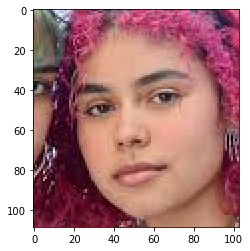

10 5


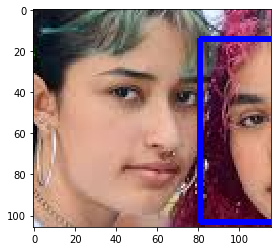

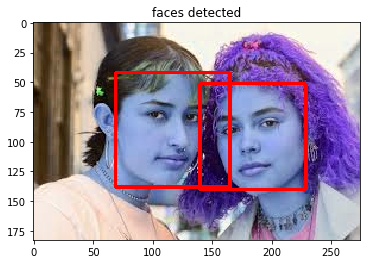

In [4]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for i, (x,y,w,h) in enumerate(faces):
    x_pad = abs(int((h-y)*0.2))
    y_pad = abs(int((x-w)*0.2))
    print(x_pad,y_pad)
    face = img[y-y_pad:y+h+y_pad, x-x_pad:x+w+x_pad]
    plt.imshow(face[:,:,::-1])
    plt.show()
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    #img = cv2.circle(img,(x,y),1,(255,255,0),2)
    #img = cv2.circle(img,(x+w,y),1,(255,255,0),2)
    #img = cv2.circle(img,(x,y+h),1,(255,255,0),2)
    #img = cv2.circle(img,(x+w,y+h),1,(255,255,0),2)

# print image
plt.imshow(img)
plt.title('faces detected')
plt.show()

In [5]:
def getFaceBox(net, frame, conf_threshold=0.7):
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], True, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append([x1, y1, x2, y2])
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

faceProto = "opencv_face_detector.pbtxt"
faceModel = "opencv_face_detector_uint8.pb"

ageProto = "age_deploy.prototxt"
ageModel = "age_net.caffemodel"

genderProto = "gender_deploy.prototxt"
genderModel = "gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
genderList = ['Male', 'Female']

# Load network
ageNet = cv2.dnn.readNet(ageModel, ageProto)
genderNet = cv2.dnn.readNet(genderModel, genderProto)
faceNet = cv2.dnn.readNet(faceModel, faceProto)

Gender : Female, conf = 1.000
Age Output : [[7.0522619e-05 4.4794902e-02 9.5098424e-01 3.6190284e-04 3.4995095e-03
  2.6371973e-04 1.1741053e-05 1.3490859e-05]]
Age : (8-12), conf = 0.951
Gender : Female, conf = 0.948
Age Output : [[3.1470900e-05 8.6284599e-05 9.9424428e-01 9.5453179e-05 3.2580786e-03
  1.2331156e-03 7.6760109e-05 9.7444851e-04]]
Age : (8-12), conf = 0.994


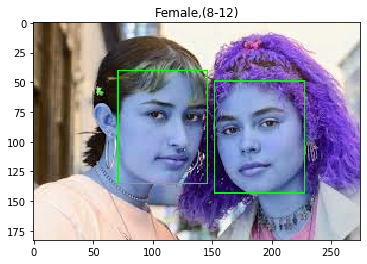

In [6]:
padding = 20
frame = cv2.imread('images/sample1.jpg')
frameFace, bboxes = getFaceBox(faceNet, frame)
for bbox in bboxes:
    # print(bbox)
    face = frame[max(0,bbox[1]-padding):min(bbox[3]+padding,frame.shape[0]-1),max(0,bbox[0]-padding):min(bbox[2]+padding, frame.shape[1]-1)]

    blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
    genderNet.setInput(blob)
    genderPreds = genderNet.forward()
    gender = genderList[genderPreds[0].argmax()]
    # print("Gender Output : {}".format(genderPreds))
    print("Gender : {}, conf = {:.3f}".format(gender, genderPreds[0].max()))

    ageNet.setInput(blob)
    agePreds = ageNet.forward()
    age = ageList[agePreds[0].argmax()]
    print("Age Output : {}".format(agePreds))
    print("Age : {}, conf = {:.3f}".format(age, agePreds[0].max()))

    label = "{},{}".format(gender, age)
    
    plt.imshow(frameFace)
    plt.title(label)
plt.show()
    #cv2.putText(frameFace, label, (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
    #cv2.imshow("Age Gender Demo", frameFace)
    # cv.imwrite("age-gender-out-{}".format(args.input),frameFace)